In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import nibabel as nib
from scipy.ndimage import zoom

import random
import torch

from preprocessing_utils import preprocess_scale, calc_mean_std

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

torch.set_default_dtype(torch.float32) 

Device: cuda


In [ ]:
def set_seed(seed=42):
    # Set seed for reproducibility
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

set_seed(42)

### Selecting a random test and validation participant

The data was divided into training, validation and test data. The total number of participants were 9, where 7 were used as training data and the remaining two were used for validation and test.

In [ ]:
random.seed(42)
TEST_PARTICIPANT = random.randint(0,9)
VAL_PARTICIPANT = random.randint(0,8) # 8 data points left after removing the test participant
print(f'Test participant index: {TEST_PARTICIPANT}')
print(f'Val participant index: {VAL_PARTICIPANT}')

Test participant index: 1
Val participant index: 0


### Loading the processed k-space data

In [ ]:
folder_path = '../../data/KSPACE/k-space/preprocessing/final_data' 

In [5]:
file_list = sorted([f for f in os.listdir(folder_path) if f.endswith('.npy')])

In [6]:
k_space_data = [np.load(os.path.join(folder_path, file)) for file in file_list]

### Splitting into training, test and validation data

In [10]:
k_space_data_test = [k_space_data[TEST_PARTICIPANT]]
k_space_data_train_val = [k_space for i, k_space in enumerate(k_space_data) if i != TEST_PARTICIPANT]

k_space_data_val = [k_space_data_train_val[VAL_PARTICIPANT]]
k_space_data_train = [k_space for i, k_space in enumerate(k_space_data_train_val) if i != VAL_PARTICIPANT]

In [11]:
print(f'Number of participants in training data: {len(k_space_data_train)}')
print(f'Number of participants in validation data: {len(k_space_data_val)}')
print(f'Number of participants in test data: {len(k_space_data_test)}')

Number of participants in training data: 7
Number of participants in validation data: 1
Number of participants in test data: 1


(2, 52, 128, 128, 128) complex128


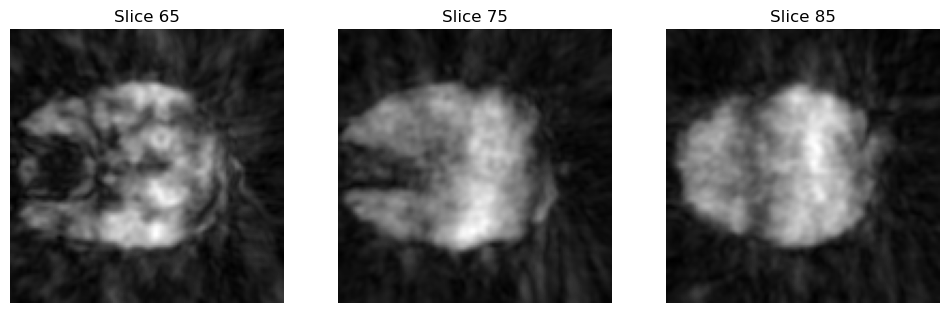

In [18]:
def sanity_check(kspace_data):
    """ 
    Sanity check to ensure the preprocessing of k-space was performed correctly. 
    Computes the inverse Fourier transform to visualize the image. 

    Specified to take the first volume in the training set and reconstructed at timepoint 27, but can be changed if desired.

    Parameters:
    - kspace_data: Processed k-space data with shape [channels, time, z, y, x]

    Returns:
    - image: Reconstructed image in image space.

    """
    real = kspace_data[0][0,27,:,:,:]
    imag = kspace_data[0][1,27,:,:,:]
    comb = real + 1j*imag

    image = np.fft.ifftn(comb, axes=(-3,-2,-1))
    image = np.fft.ifftshift(image, axes=(-3,-2,-1))
    return image

print(k_space_data_train[0].shape, k_space_data_train[0].dtype)
sanity_train = sanity_check(k_space_data_train)

slices = [65, 75, 85]
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Plot each slice
for i, slice_idx in enumerate(slices):
    ax = axes[i]
    ax.imshow(np.abs(sanity_train[slice_idx,:,:]), cmap='gray')
    ax.set_title(f"Slice {slice_idx}")
    ax.axis('off')  



### From 4D to 3D

To train the 3D-UNet, the 4D volumes with the temporal dimension included, were split into multiple 3D volumes.

[t, z, y, x] → t * [z, y, x]

Resulting in 52 3D data points for each 4D volume.

In [ ]:
def time_data(data, KSPACE = True):
    """ 
    Split 4D volume into multiple 3D volumes across the time dimension.

    For k-space: shape = (channels, t, z, y, x) → list of (channels, z, y, x)
    For image space: shape = (z, y, x, t) → list of (z, y, x)

    Parameters:
    - data: Input 4D array (k-space or image space).
    - KSPACE: Boolean value to split data differenty depending on if it is input-data (k-space) or ground truth data (image space)

    Return:
    - split_data: List of time-separated 3D volumes.
    """

    if KSPACE:
        split_data = [data[:,i,:,:,:].real.astype(np.float32) for i in range(data.shape[1])] 
        
    else:
        split_data = [data[:,:,:,i] for i in range(data.shape[-1])] 

    return split_data

In [11]:
X_train = []
for data in k_space_data_train:
    X_train.extend(time_data(data))

X_val = []
for data in k_space_data_val:
    X_val.extend(time_data(data))

X_test = []
for data in k_space_data_test:
    X_test.extend(time_data(data))
    

### Calculating the mean and standard deviation of training data

The mean and standard deviation (std) of the training set will be used for normalization. Training, validation, and test data are all normalized with the mean and std of the training data.

In [12]:
mean_X_train, std_X_train = calc_mean_std(X_train)

print(f'Mean X data: {mean_X_train}, Std X data: {std_X_train}')

Mean X data: 0.009233590215444565, Std X data: 7.496199607849121


### Normalizing and scaling the k-space data

The k-space data gets saved in specific folders (see preprocess_scale() in preprocessing_utils.py)

In [13]:
preprocess_scale(X_train, mean_X_train, std_X_train, normalize = True, if_X=True, val=False, test=False)

In [14]:
preprocess_scale(X_val, mean_X_train, std_X_train, normalize = True, if_X=True, val=True, test=False)

In [15]:
preprocess_scale(X_test, mean_X_train, std_X_train, normalize = True, if_X=True, val=False, test=True)

### Loading the NIFTY files of Looping Star images

The NIFTY files were used as ground truth for the 3D-UNet. They were loaded and preprocessed in the same manner as the k-space data. Due to size difference, the ground truth volumes were resized. After visualization, the volumes were also flipped to match the orientation of the k-space data.

In [ ]:
ls_path = "../../data/KSPACE/ls_te_1"
ls_files = [f for f in os.listdir(ls_path) if f.endswith(".nii")] 

ls_images = [] 

for i, filename in enumerate(ls_files, start=1):
    file_path = os.path.join(ls_path, filename)
    ls_images.append(nib.load(file_path).get_fdata())

# Selecting the same timepoints as were subsampled for k-space data
ls_images_sliced = [image[:,:,:,120:172] for image in ls_images]

### Splitting into training, validation, and test data

The same participants chosen at the top of the notebook were used as the same data splitting.

In [ ]:
ls_images_sliced_test = [ls_images_sliced[TEST_PARTICIPANT]]
ls_images_sliced_train_val = [ls_img for i, ls_img in enumerate(ls_images_sliced) if i != TEST_PARTICIPANT]

ls_images_sliced_val = [ls_images_sliced[VAL_PARTICIPANT]]
ls_images_sliced_train = [ls_img for i, ls_img in enumerate(ls_images_sliced_train_val) if i != VAL_PARTICIPANT]

#### 4D → 3D

The temporal splitting was performed in the same manner as for the k-space data.

In [8]:
images_train = []
for data in ls_images_sliced_train:
    images_train.extend(time_data(data, KSPACE=False))

images_val = []
for data in ls_images_sliced_val:
    images_val.extend(time_data(data, KSPACE=False))

images_test = []
for data in ls_images_sliced_test:
    images_test.extend(time_data(data, KSPACE=False))

#### Flipping and resizing ground truth

Due to the size difference in the k-space data and the ground truth volumes, the labels were resized to accomodate for the size difference. The images were also flipped, to match the reconstruction of the k-space data.

In [ ]:
def flip_and_resize(image, target_size=(128,128,128)):
    """ 
    Flipping and resizing image data.
    Original size: (64, 64, 64)
    Desired size: (128, 128, 128)
    Flipping image to align with the orientation of the k-space data.

    Parameters:
    - image: 3D volume to be resized
    - target_size: Desired shape after resizing. Default (128, 128, 128)

    Returns:
    - flipped_image: Resized and flipped image.
    """
    H_target, W_target, D_target = target_size
    H, W, D = image.shape[:3]
    zoom_factors = tuple([H_target/H, W_target/W, D_target/D])

    resized_image = zoom(image, zoom_factors, order=1) 
    flipped_image = np.fliplr(resized_image)
    return flipped_image

In [10]:
y_train = [flip_and_resize(image) for image in images_train]
y_val = [flip_and_resize(image) for image in images_val]
y_test = [flip_and_resize(image) for image in images_test]

### Computing mean and standard deviation of training data

In [11]:
mean_y_train, std_y_train = calc_mean_std(y_train)

print(f'Mean y data: {mean_y_train}, Std y data: {std_y_train}')

Mean y data: 1263.6338048120901, Std y data: 1153.8820001530814


### Preprocessing and saving the data

In [ ]:
preprocess_scale(y_train, mean_y_train, std_y_train, normalize = True, if_X=False, val=False, test=False)

In [ ]:
preprocess_scale(y_val, mean_y_train, std_y_train, normalize = True, if_X=False, val=True, test=False)

In [14]:
preprocess_scale(y_test, mean_y_train, std_y_train, normalize = True, if_X=False, val=False, test=True)